In [22]:
import pandas as pd
import numpy as np
from common import collect_results, normalize_region_name
from pathlib import Path
from matplotlib import pyplot as plt

In [31]:
ROOT = Path("./read-only")

def get_matcher(prefix):
    def matcher(p: Path):   
        import re
        pattern = re.compile(prefix + r"-hot(\d+)-(\w)-mr(\d+)-([\d-]+)")
        match = pattern.match(p.name)
        if not match:
            return None

        print("Found result:", p.name)
        hot = int(match.group(1))
        return {
            "hot": 1000000 if hot == 0 else hot,
            "workload": str(match.group(2)),
            "mr": int(match.group(3)),
            "suffix": str(match.group(4)),
        }
    
    return matcher

# Throughput


In [32]:
SYSTEMS = ["sunstorm", "aurora-global", "aurora-eventual", "yugabyte"]
HOTS = [100000, 1000]
RENEW_CACHE = False

sunstorm_matcher = get_matcher("ycsb-read-only-sunstorm")
sunstorm_throughput_df = collect_results(
    ROOT / "sunstorm",
    sunstorm_matcher,
    RENEW_CACHE,
)
sunstorm_throughput_df["system"] = "sunstorm"

aurora_global_matcher = get_matcher("ycsb-read-only-aurora")
aurora_global_throughput_df = collect_results(
    ROOT / "aurora",
    aurora_matcher,
    RENEW_CACHE,
)
aurora_global_throughput_df["system"] = "aurora-global"


aurora_eventual_matcher = get_matcher("ycsb-read-only-aurora")
aurora_eventual_throughput_df = collect_results(
    ROOT / "aurora-eventual",
    aurora_eventual_matcher,
    RENEW_CACHE,
)
aurora_eventual_throughput_df["system"] = "aurora-eventual"

yugabyte_matcher = get_matcher("ycsb-read-only-yugabyte")
yugabyte_throughput_df = collect_results(
    ROOT / "yugabyte",
    yugabyte_matcher,
    RENEW_CACHE,
)
yugabyte_throughput_df["system"] = "yugabyte"

In [33]:
throughput_df = pd.concat([
    sunstorm_throughput_df,
    aurora_global_throughput_df,
    aurora_eventual_throughput_df,
    yugabyte_throughput_df,
])
throughput_df["HOT"] = 1 / throughput_df["hot"]
normalize_region_name(throughput_df)
throughput_df

print(throughput_df.system.unique())

['sunstorm' 'aurora-global' 'aurora-eventual' 'yugabyte']


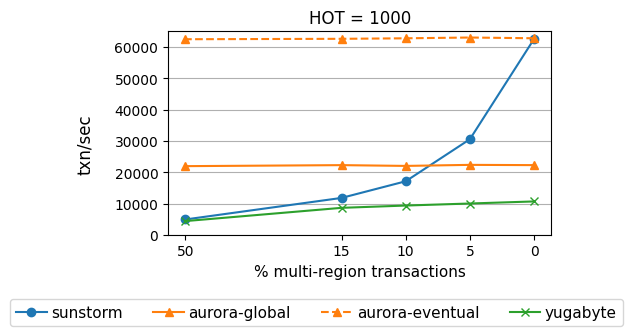

In [96]:
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

plt.rc('axes', labelsize=11) 
plt.rc('legend', fontsize=11)


fig = plt.figure(figsize=(5, 3))
gs = GridSpec(1, 1, figure=fig)

for h, hot in enumerate([1000]):
    ax = fig.add_subplot(gs[h])
    hot_df = throughput_df[throughput_df.hot == hot]
    hot_label = hot
    pivotted = hot_df.pivot_table(
        index=["mr"], columns=["system"], values="throughput", aggfunc="sum"
    )[SYSTEMS].plot(
        title=f"HOT = {hot_label}",
        # xlabel="% multi-region transactions",
        # ylabel="txn/sec",
        # figsize=(5, 2.5),
        style=["o-", "^-", "^--", "x-"],
        color=["C0", "C1", "C1", "C2"],
        ylim=(0, 65000),
        rot=0,
        ax = ax
    )
    ax.set_xscale("symlog", linthresh=20)
    ax.set_xticks([0, 5, 10, 15, 50])
    ax.set_xticklabels([0, 5, 10, 15, 50])
    if h == 1:
        ax.set_yticklabels([])
    ax.margins(x=0.05)
    ax.grid(axis="y")
    ax.set_xlabel("% multi-region transactions")
    ax.set_ylabel("")
    ax.get_legend().remove()
    # ax.legend(title="", ncol=4, handletextpad=0.3)
    ax.invert_xaxis()
    #plt.savefig(f"output/micro-throughput-hot{hot}.pdf", bbox_inches="tight")
handles=[
    Line2D([0], [0],  marker='o', linestyle='-', color='C0', markerfacecolor='C0', label='sunstorm'),
    Line2D([0], [0],  marker='^', linestyle='-',color='C1', markerfacecolor='C1', label='aurora-global'),
    Line2D([0], [0],  marker='^', linestyle='--',color='C1', markerfacecolor='C1', label='aurora-eventual'),
    Line2D([0], [0],  marker='x', linestyle='-',color='C2', markerfacecolor='C2', label='yugabyte'),]

fig.supylabel("txn/sec", y=0.5)
#fig.supxlabel("% multi-region transactions", x=0.5)

fig.legend(handles=handles, 
           title="",
           ncol=4,
           loc="upper center",
           handletextpad=0.3,
           bbox_to_anchor=(0.5,0.01)  # Adjust legend position if needed
          )
fig.tight_layout()
fig.savefig("micro-read-only.pdf", bbox_inches="tight")




# Latency


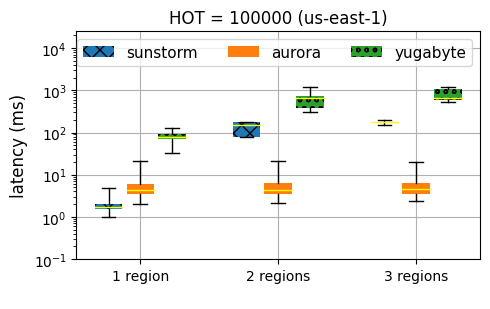

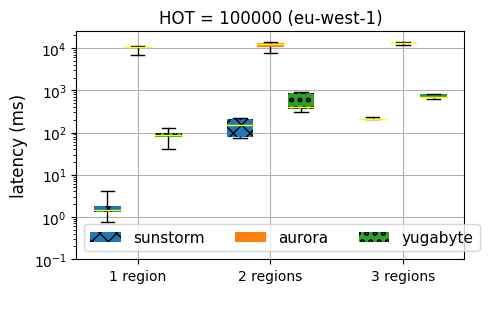

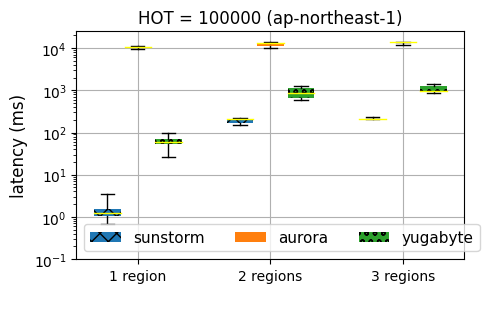

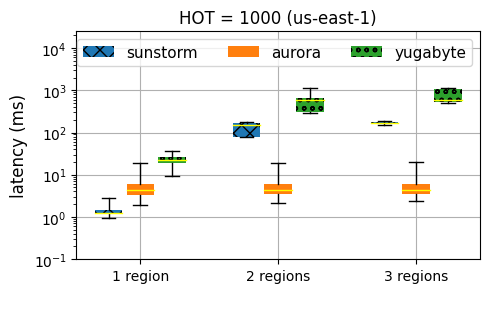

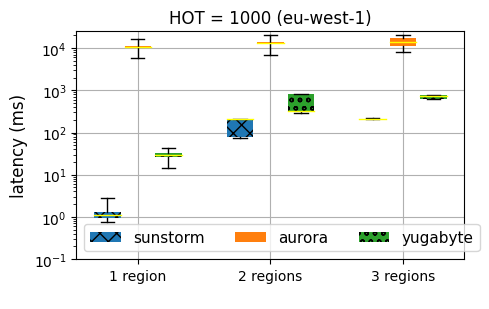

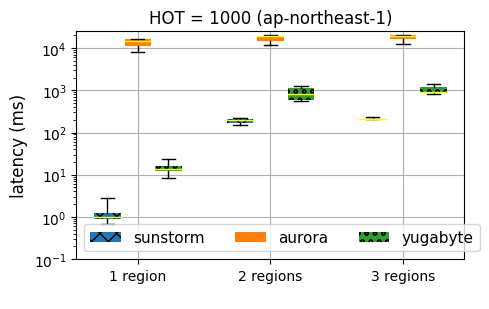

In [19]:
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

labels = [
    "1 region\n",
    "2 regions\n",
    "3 regions\n",
]
ticks = np.arange(len(labels))

width = 0.46

def to_box(df, n):
    return {
        'whislo': df[f"p0.WorkloadC{n}"].iloc[0],
        'q1': df[f"p25.WorkloadC{n}"].iloc[0],
        'med': df[f"p50.WorkloadC{n}"].iloc[0],
        'q3': df[f"p75.WorkloadC{n}"].iloc[0],
        'whishi': df[f"p99.WorkloadC{n}"].iloc[0],
        'fliers': []
    }

legends = []
patterns = ["xx", "", "oo"]

for hot in [100000, 1000]:
    hot_df = throughput_df[throughput_df.hot == hot]
    hot_label = hot
    for region in ["1-us-east-1", "2-eu-west-1", "3-ap-northeast-1"]:
        region_df = hot_df[hot_df.region.str.startswith(region)]

        fig, ax = plt.subplots(figsize=(5, 3.2))
        for i, system in enumerate(SYSTEMS):
            system_df = region_df[region_df.system == system]
            # boxes = [
            #     to_box(system_df[system_df.mr == 5], 1),
            #     to_box(system_df[system_df.mr == 5], 2),
            #     to_box(system_df[system_df.mr == 5], 3),
            # ]
            boxes = [
                to_box(system_df, 1),
                to_box(system_df, 2),
                to_box(system_df, 3),
            ]
            comps = ax.bxp(
                boxes,
                positions=ticks - width / 2 + i * width / (len(SYSTEMS) - 1),
                showfliers=False,
                manage_ticks=False,
                patch_artist=True,
                widths=0.2,
                boxprops={
                    "facecolor": f"C{i}",
                    "linewidth": 0,
                    "hatch": patterns[i],
                },
                medianprops={
                    "color": "yellow",
                    "linewidth": 1,
                },
            )
            legends.append(comps["boxes"][0])

        ax.legend(legends, SYSTEMS, ncol=3)

        ax.set_xticks(labels=labels, ticks=ticks)
        ax.set_yscale("log")
        ax.set_ylim(0.1, 25000)
        ax.set_ylabel("latency (ms)")
        ax.grid()

        ax.set_title(f"HOT = {hot_label} ({region[2:]})")
        fig.tight_layout()
        # fig.savefig(f"output/micro-latency-{region[2:]}-hot{hot}.pdf", bbox_inches="tight")


In [10]:
def plot_latency(mr, hot):
    # Remove the "-0" suffix in region name
    throughput_df['region'] = throughput_df['region'].str.replace(r'-0', '', regex=True)
    regions = sorted([r for r in set(throughput_df.region.unique()) if not r.endswith("-0")])
    for system in throughput_df.system.unique():
        fig, axes = plt.subplots(1, len(regions), figsize=(20, 4), sharey=True)
        fig.suptitle(f"{system}, hot = {hot}, mr = {mr}%")
        workload_df = throughput_df[
            (throughput_df.system == system)
            & (throughput_df.mr == mr)
            & (throughput_df.hot == hot)
        ]
        # Plot for each region
        for i, region in enumerate(regions):
            region_df = workload_df[workload_df.region.str.startswith(region)]
            if region_df.empty:
                continue
            # Seperate the tran sactions by the number of regions they access
            max_nregion = 3
            index = range(1, max_nregion + 1)
            nregion_latency_df = {
                "p0": [region_df[f"p0.WorkloadC{n}"].iloc[0] for n in index],
                "p25": [region_df[f"p25.WorkloadC{n}"].iloc[0] for n in index],
                "p50": [region_df[f"p50.WorkloadC{n}"].iloc[0] for n in index],
                "p75": [region_df[f"p75.WorkloadC{n}"].iloc[0] for n in index],
                "p95": [region_df[f"p95.WorkloadC{n}"].iloc[0] for n in index],
                "p99": [region_df[f"p99.WorkloadC{n}"].iloc[0] for n in index],
            }
            pd.DataFrame(nregion_latency_df, index=index).plot.bar(
                title=region,
                ylabel="latency (ms)",
                ax=axes[i],
                rot=0,
                ylim=(1, 1200),
                logy=True,
            )
            axes[i].set_xlabel("number of regions")
            axes[i].grid(axis="y")
        plt.tight_layout()

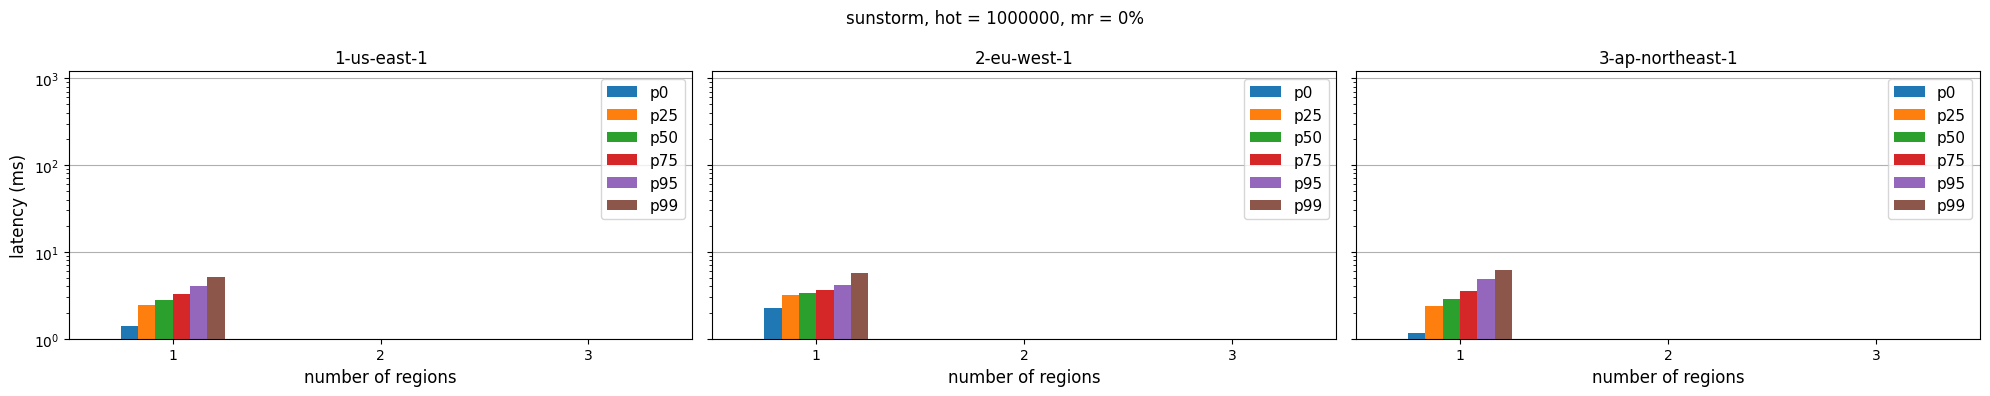

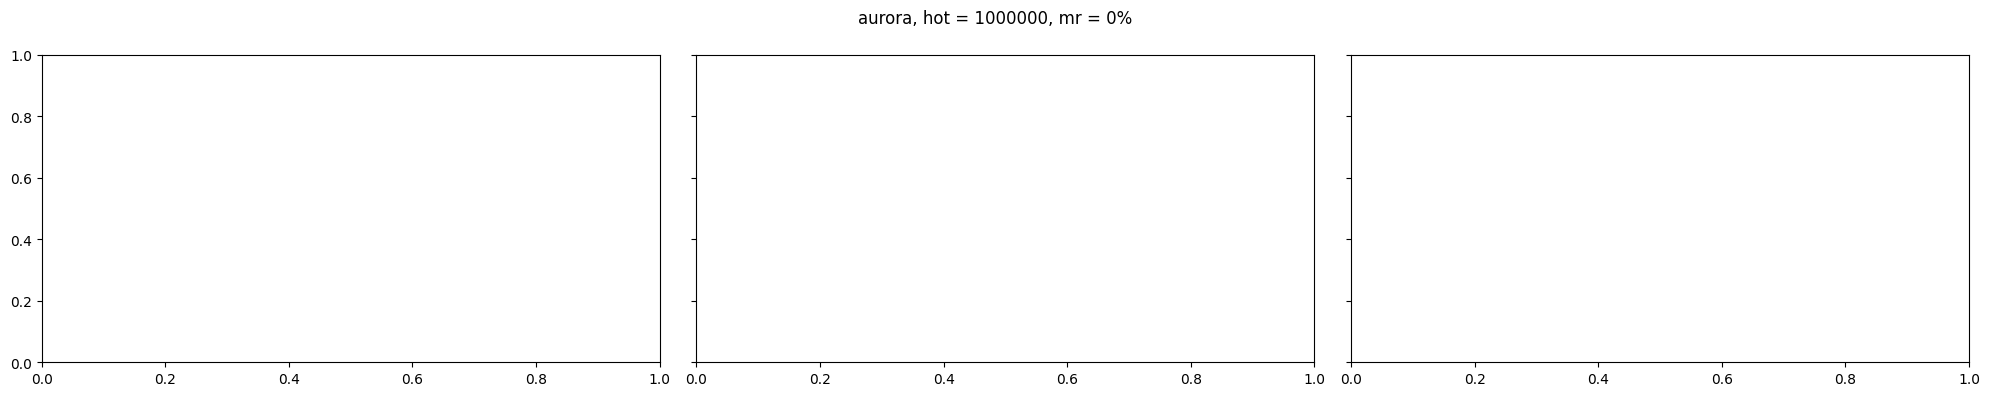

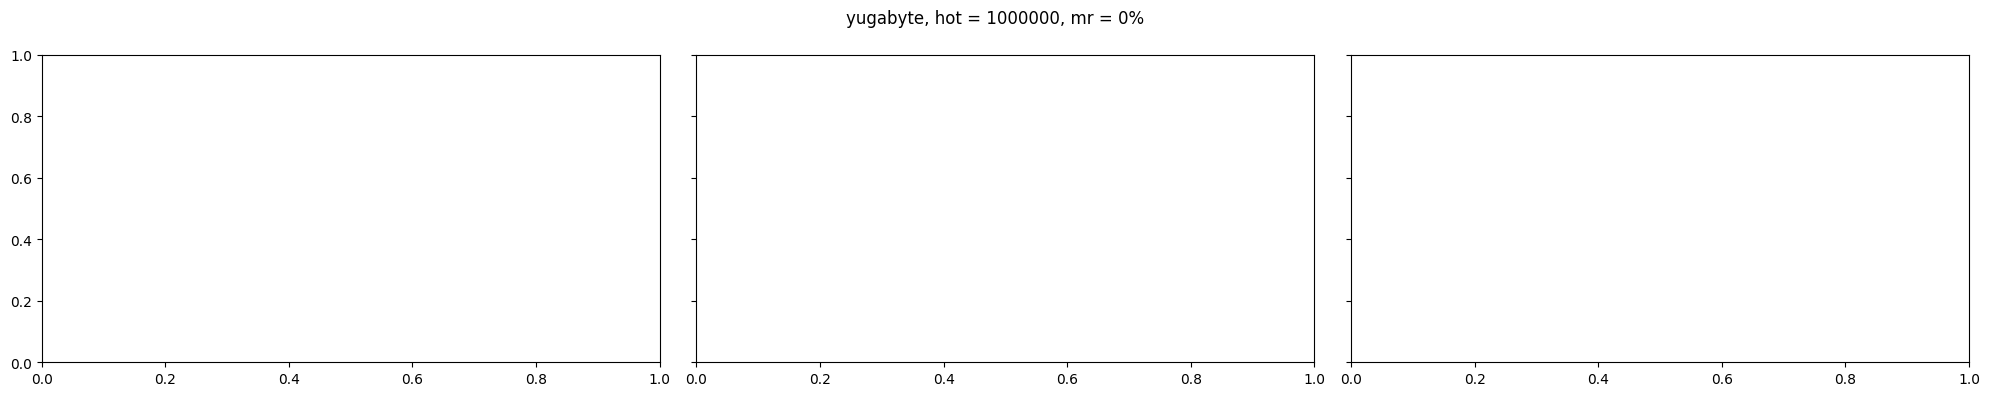

In [11]:
plot_latency(0, 1000000)

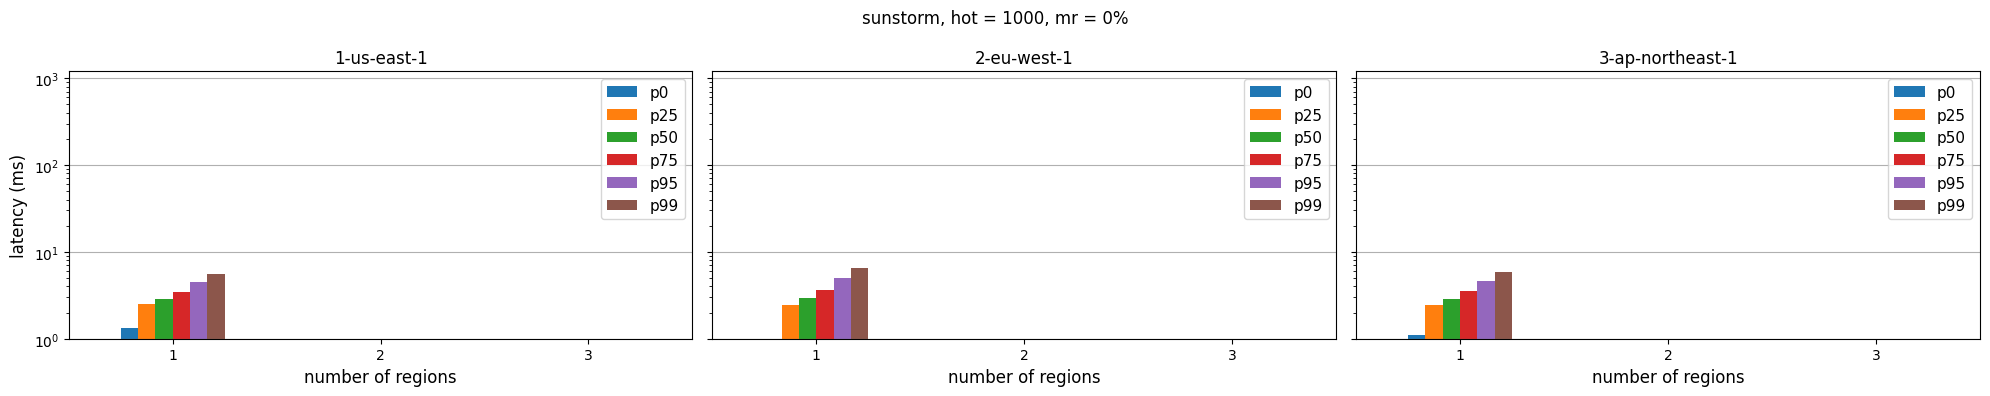

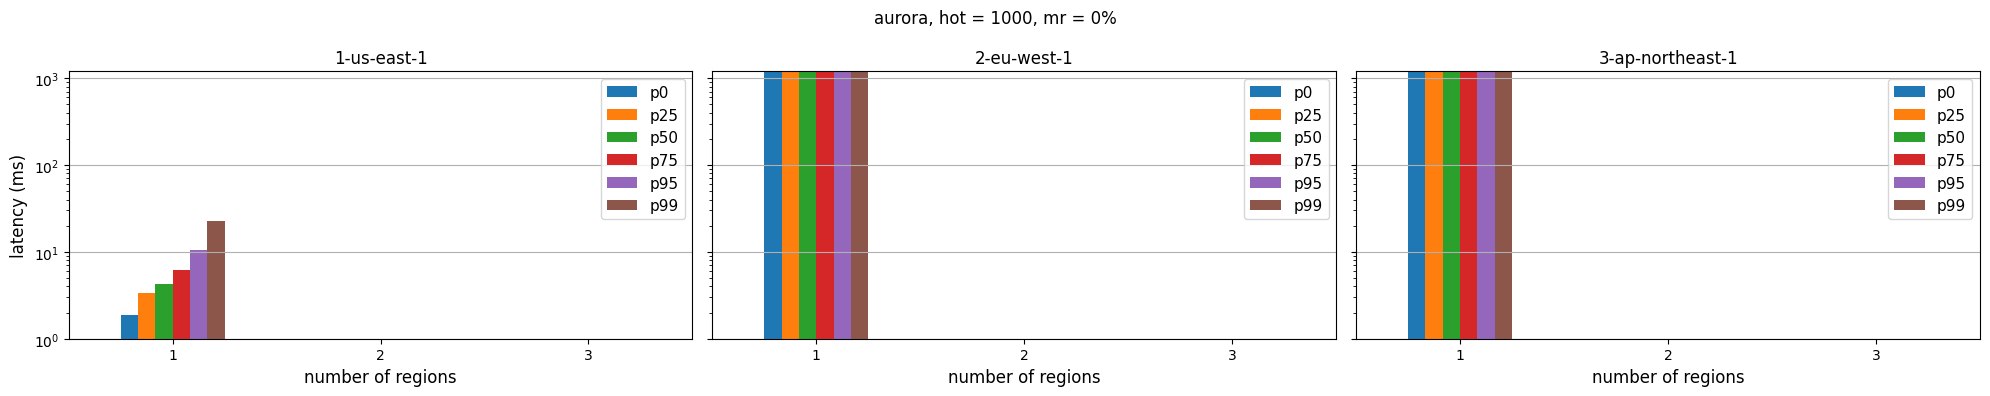

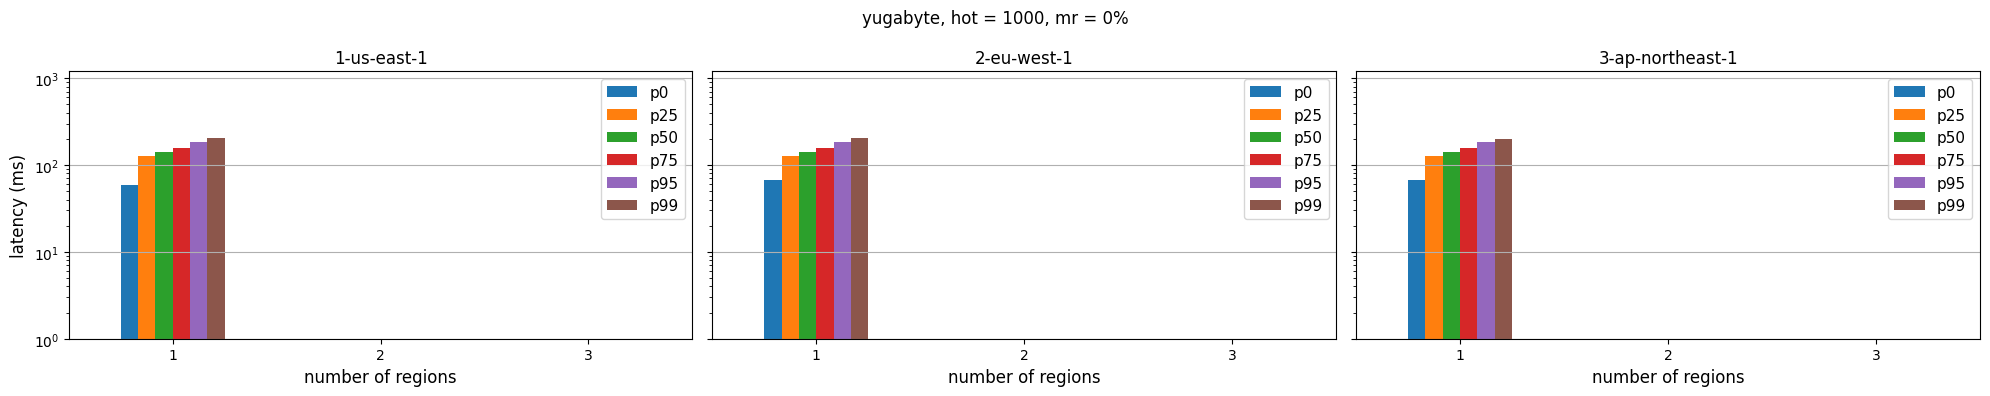

In [12]:
plot_latency(0, 1000)

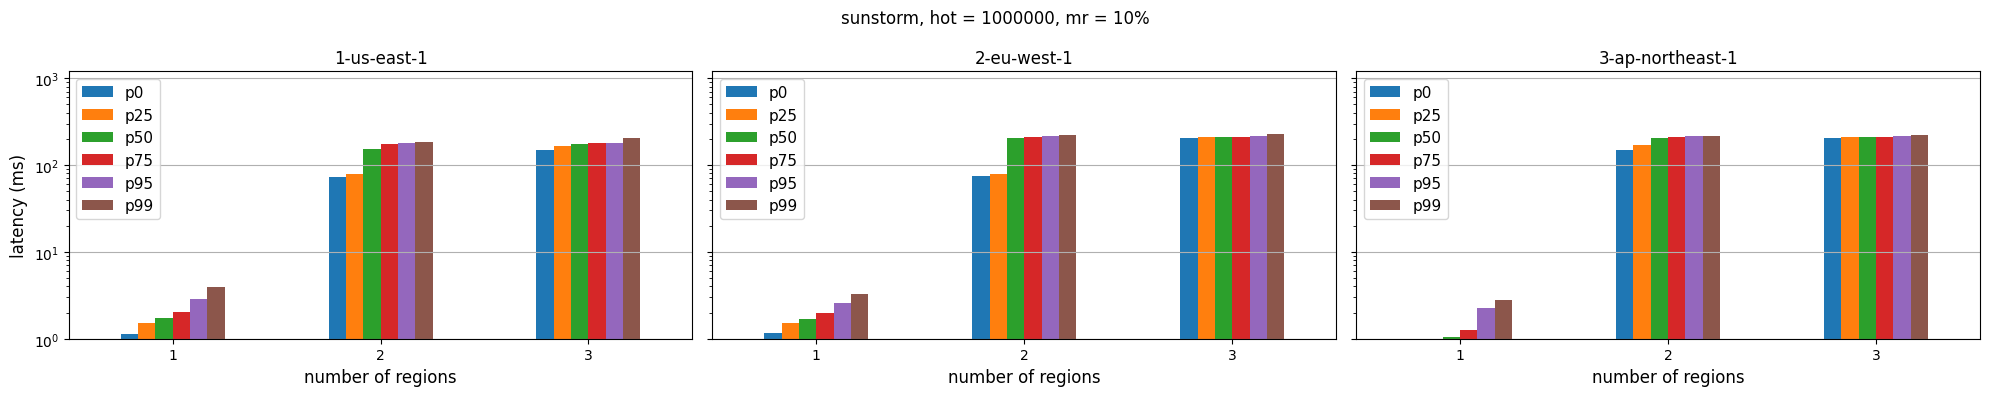

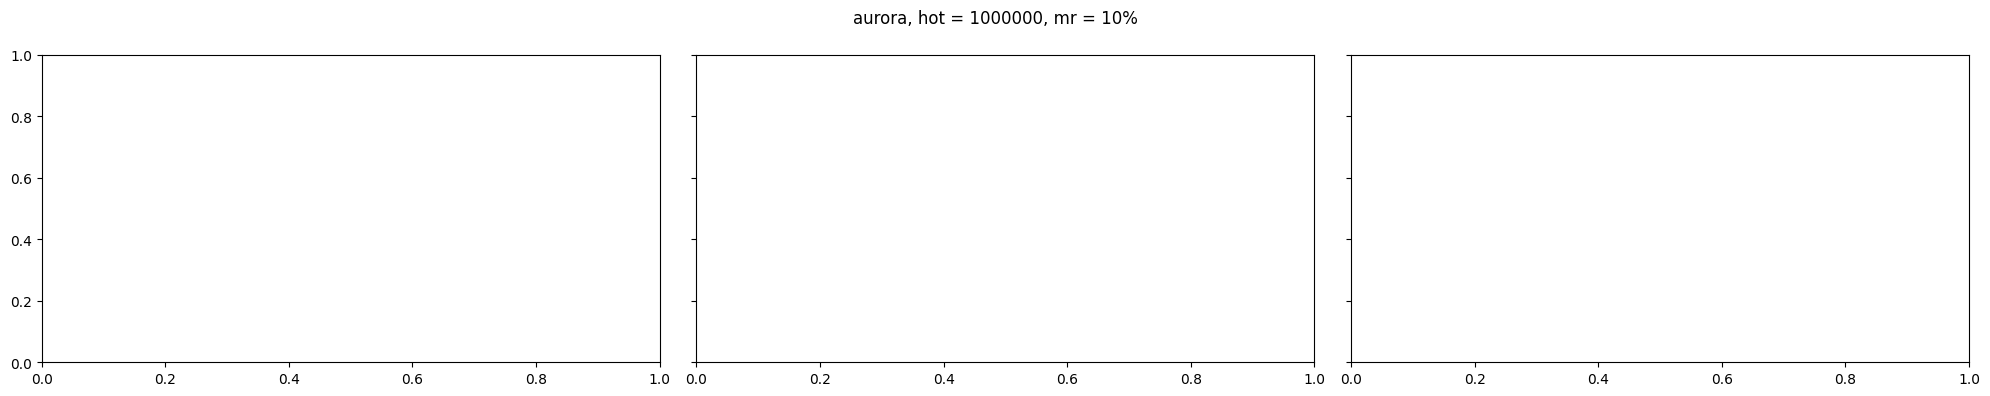

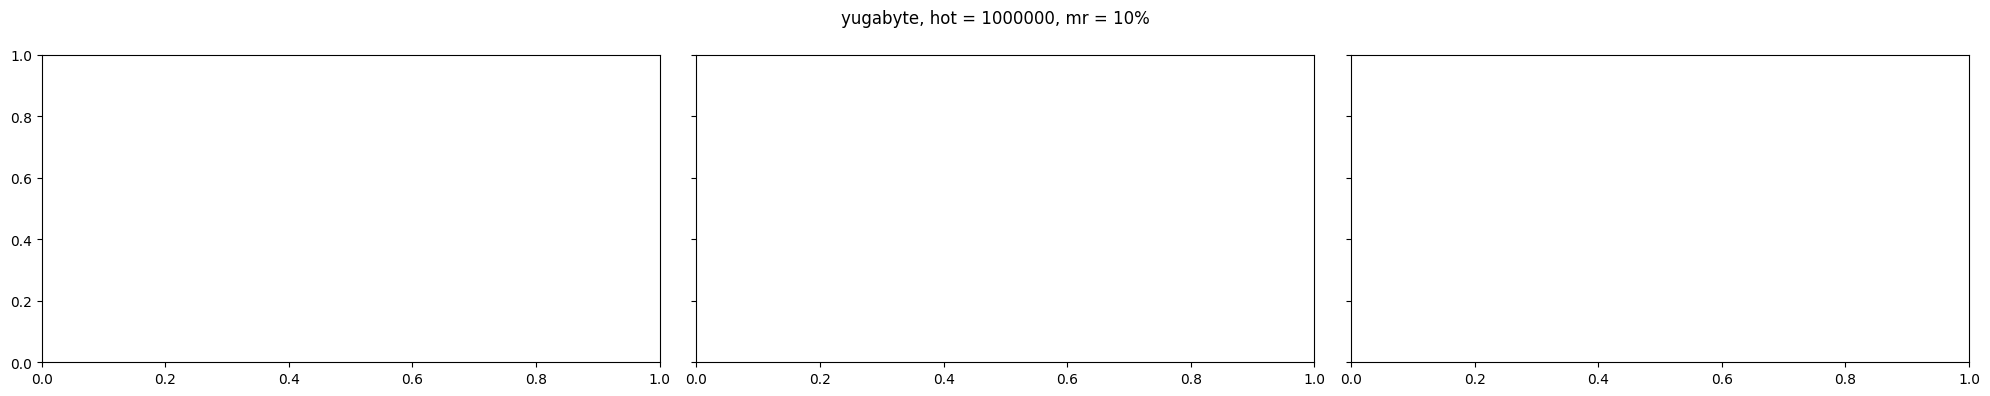

In [13]:
plot_latency(10, 1000000)

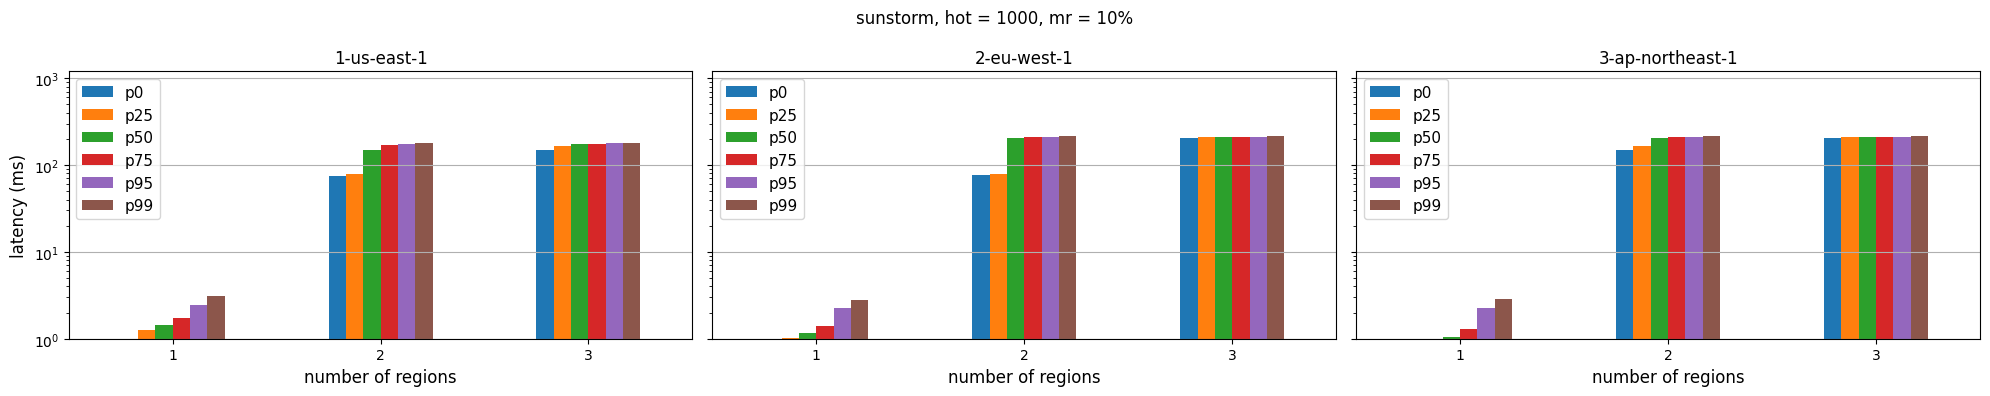

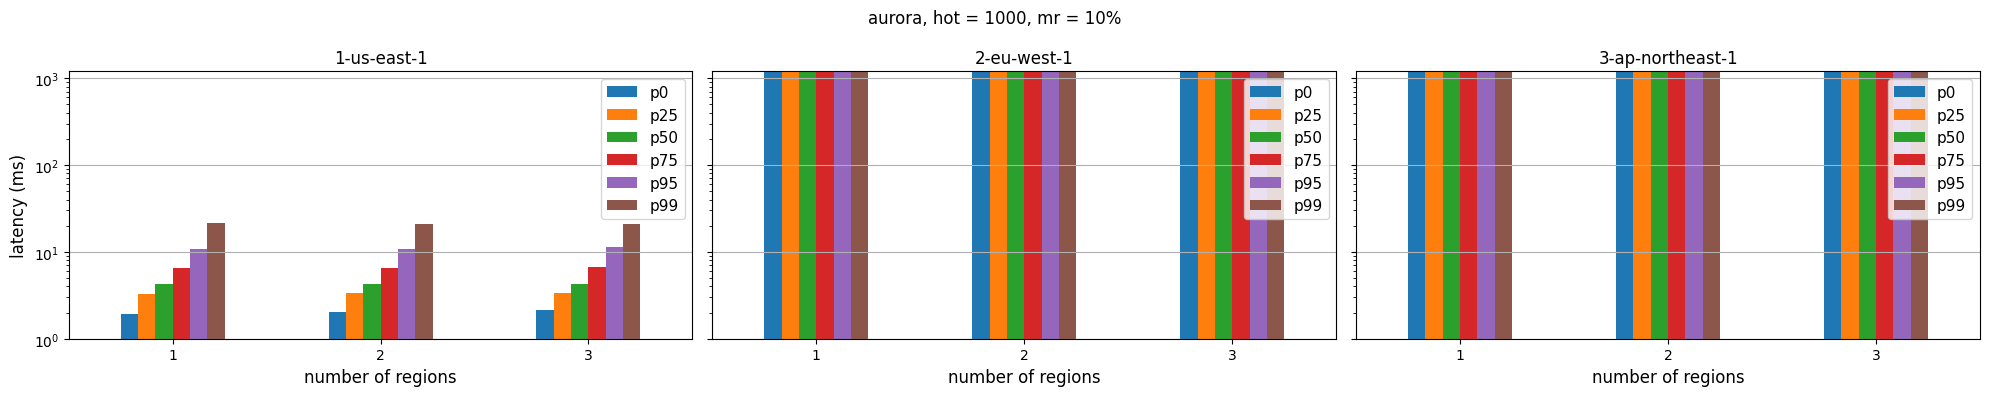

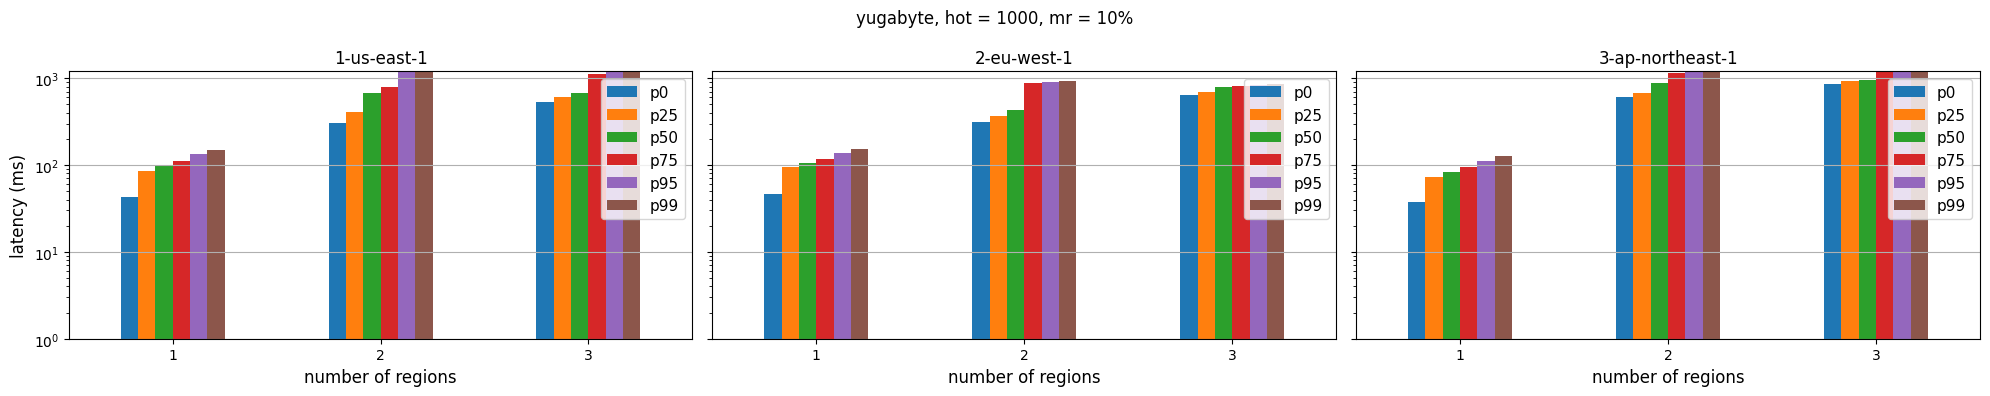

In [14]:
plot_latency(10, 1000)

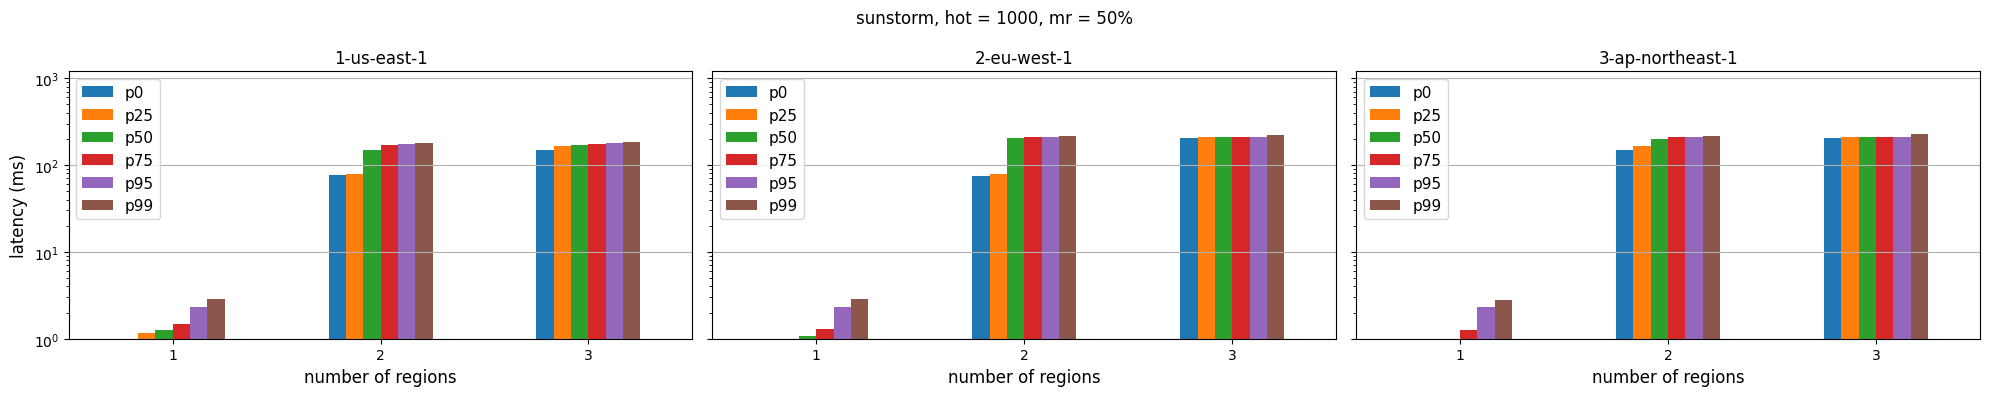

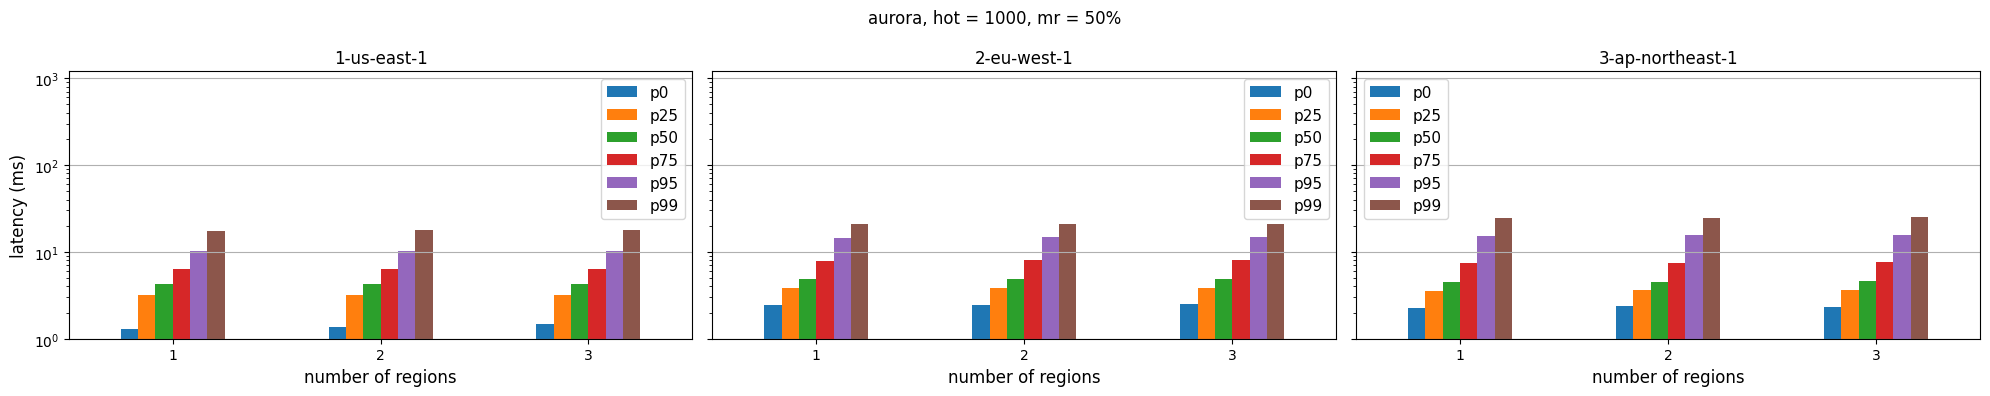

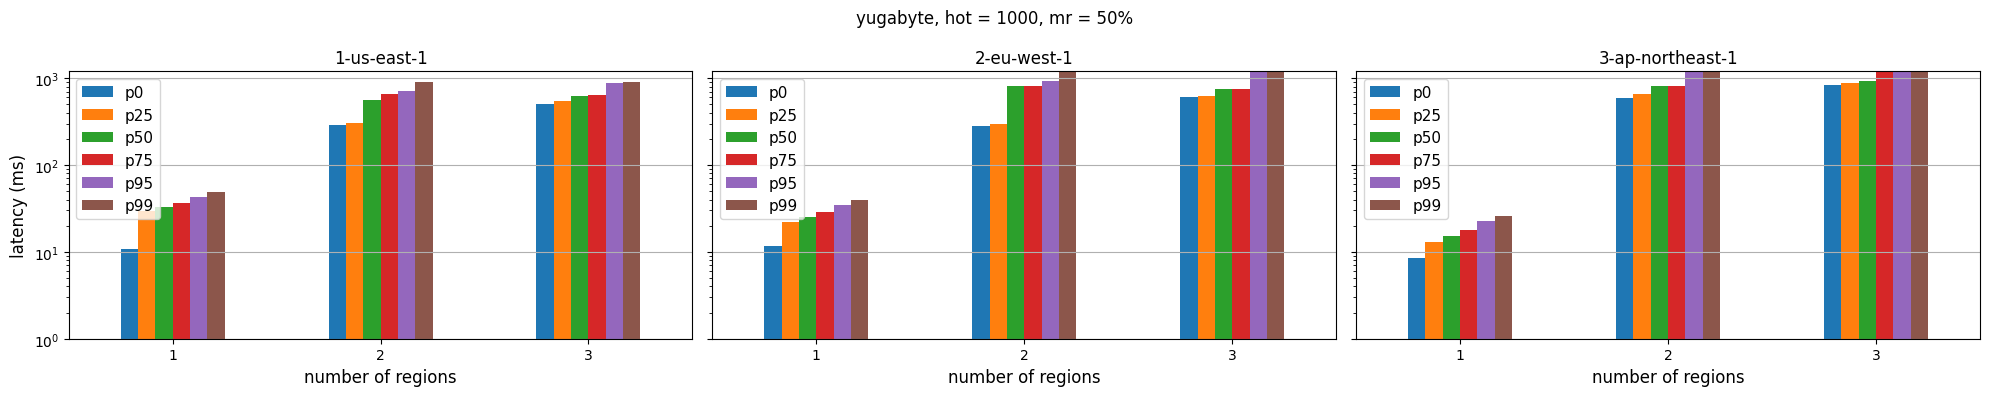

In [15]:
plot_latency(50, 1000)